# Set up

In [ ]:
!pip install -q lightning

# ENV

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import lightning as L
from tqdm.auto import tqdm

from einops.layers.torch import Reduce, Rearrange
from einops import reduce, rearrange, repeat, einsum, parse_shape, pack, unpack

In [ ]:
import seaborn as sns
sns.set()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['lines.linewidth']=2

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [ ]:
seed=42
L.seed_everything(seed)

torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
device='cuda' if torch.cuda.is_available() else 'cpu'
device

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


'cpu'

# Data

In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split

class DataModule(L.LightningDataModule):
    def __init__(self,batch_size=32):
        super().__init__()
        self.batch_size=batch_size
        self.image_size=[3,32,32]
        self.num_classes=10

    def prepare_data(self):
        train_dataset = CIFAR10('.', train=True, download=True)
        self.data_mean = (train_dataset.data / 255.0).mean(axis=(0,1,2))
        self.data_std = (train_dataset.data / 255.0).std(axis=(0,1,2))
        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.data_mean, self.data_std)
        ])

    def setup(self, stage=None):
        if stage=='fit' or stage is None:
            dataset=CIFAR10('.', download=True, train=True, transform=self.transform)
            self.train, self.val = random_split(dataset, [45000, 5000])
        if stage=='test' or stage is None:
            self.test=CIFAR10('.', download=True, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False, drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=True, drop_last=True)

tmp=DataModule(128)
tmp.prepare_data()
tmp.setup()
batch=next(iter(tmp.train_dataloader()))
print(len(batch))
print(batch[0].shape)
print(batch[1].shape)

100%|██████████| 170498071/170498071 [00:02<00:00, 63906303.72it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
Files already downloaded and verified
2
torch.Size([128, 3, 32, 32])
torch.Size([128])


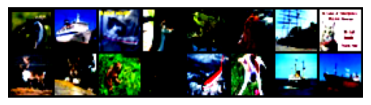

In [ ]:
from torchvision.utils import make_grid

def show_image(images, num_images=16, image_size=[3,32,32]):
    images=images.detach().cpu()
    grid_image=make_grid(images[:num_images], nrow=8)
    plt.imshow(grid_image.permute(1,2,0))
    plt.axis('off')
    plt.show()

show_image(batch[0])

In [ ]:
tmp.dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 876
})

# Architecture

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return F.relu(x)

x=torch.randn(7,3,32,32)
tmp=DepthwiseSeparableConv(3,12,2)
tmp(x).shape

torch.Size([7, 12, 16, 16])

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        self.stem = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1)

        self.body = nn.Sequential(
            DepthwiseSeparableConv(32, 64, 1),
            DepthwiseSeparableConv(64, 128, 2),
            DepthwiseSeparableConv(128, 128, 1),
            DepthwiseSeparableConv(128, 256, 2),
            DepthwiseSeparableConv(256, 256, 1),
            DepthwiseSeparableConv(256, 512, 2),
            *[DepthwiseSeparableConv(512, 512, 1) for _ in range(5)],
            DepthwiseSeparableConv(512, 1024, 2),
            DepthwiseSeparableConv(1024, 1024, 1)
        )

        self.head = nn.Sequential(nn.AvgPool2d(1),
                                  Rearrange('b c h w -> b (c h w)'),
                                  nn.Linear(1024, num_classes))

    def forward(self, x):
        x=self.stem(x)
        x=self.body(x)
        x=self.head(x)

        return x

x=torch.randn(1,3,32,32)
tmp=MobileNet(10,3)
tmp(x).shape

torch.Size([1, 10])

# Training

In [ ]:
class TrainObject(L.LightningModule):
    def __init__(self, num_classes, in_channels, lr):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization=True

        self.model=MobileNet(num_classes, in_channels)
        self.example_input_array=torch.rand([1,3,32,32])

    def criterion(self, pred, y):
        return F.cross_entropy(pred, y)

    def configure_optimizers(self):
        optimizer=torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr)
        scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

        return [optimizer], [scheduler]

    def forward(self,x):
        return self.model(x)

    def training_step(self, batch):
        imgs, labels=batch
        pred=self.model(imgs)
        loss=self.criterion(pred,labels)
        acc=(pred.argmax(dim=-1)==labels).float().mean()

        self.log('train_loss', loss, sync_dist=True, prog_bar=True)
        self.log('train_acc', acc, sync_dist=True, prog_bar=True)

        return loss

    def validation_step(self,batch):
        imgs, labels=batch
        pred=self.model(imgs)
        loss=self.criterion(pred,labels)
        acc=(pred.argmax(dim=-1)==labels).float().mean()

        self.log('val_loss', loss, sync_dist=True, prog_bar=True)
        self.log('val_acc', acc, sync_dist=True, prog_bar=True)

    def test_step(self, batch):
        imgs, labels=batch
        pred=self.model(imgs)
        loss=self.criterion(pred,labels)
        acc=(pred.argmax(dim=-1)==labels).float().mean()

        self.log('test_loss', loss, sync_dist=True, prog_bar=True)
        self.log('test_acc', acc, sync_dist=True, prog_bar=True)

In [ ]:
from lightning.pytorch.callbacks import TQDMProgressBar,EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

data_module=DataModule(128)
train_object=TrainObject(10, 3, 1e-3)
trainer=L.Trainer(accelerator='auto',
                  devices=1,
                  max_epochs=50,strategy="ddp_notebook",
                  logger=TensorBoardLogger('lightning_logs'),
                  callbacks=[TQDMProgressBar(leave=True), EarlyStopping('val_loss',min_delta=1e-5, patience=3)])
trainer.fit(train_object, data_module)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO:lightning.fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

INFO:lightning.pytorch.utilities.rank_zero:----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All di

Files already downloaded and verified
Files already downloaded and verified


INFO: 
  | Name  | Type      | Params | Mode  | In sizes       | Out sizes
-------------------------------------------------------------------------
0 | model | MobileNet | 3.2 M  | train | [1, 3, 32, 32] | [1, 10]  
-------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.825    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type      | Params | Mode  | In sizes       | Out sizes
-------------------------------------------------------------------------
0 | model | MobileNet | 3.2 M  | train | [1, 3, 32, 32] | [1, 10]  
-------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.825    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/